<a href="https://colab.research.google.com/github/claredavies/MachineLearningCoursework/blob/main/Assignment1/MLAssignment1KerrasUnbalancedData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & read in file

In [51]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [61]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('bank-additional-full.csv', sep=';', delimiter=None, header='infer', names=None, index_col=None)

Saving bank-additional-full.csv to bank-additional-full (3).csv


# Data Exploration

(41188, 21)
No claim 36548
Claim 4640
Claim proportion 11.27%


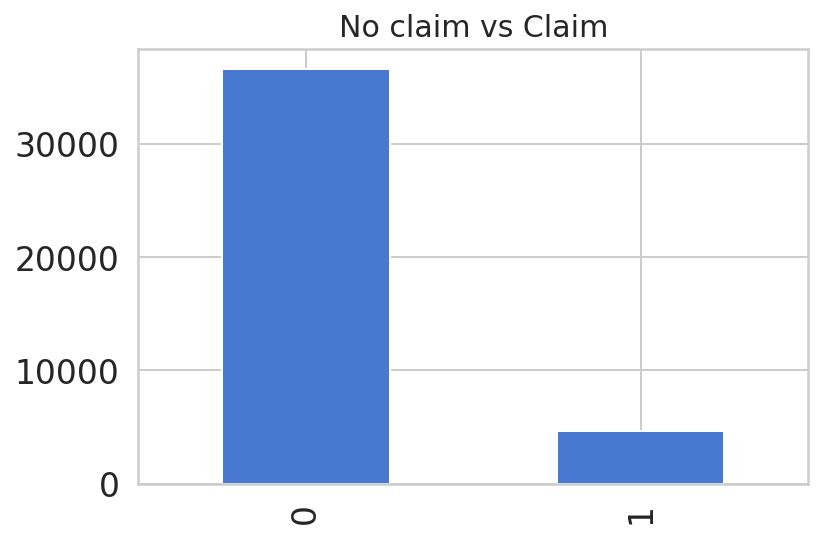

In [62]:
print(df.shape)
df.columns

def percentage(part, whole):
  return 100 * float(part) / float(whole)

df.rename(columns = {'y':'target'}, inplace = True)
df['target'] = df.target.apply(lambda x: 1 if x == "yes" else 0)

no_claim, claim = df.target.value_counts()
print(f'No claim {no_claim}')
print(f'Claim {claim}')
print(f'Claim proportion {round(percentage(claim, claim + no_claim), 2)}%')

df.target.value_counts().plot(kind="bar", title="No claim vs Claim");

## Data preprocessing

In [63]:
row_count = df.shape[0]

for c in df.columns:
  m_count = df[df[c] == -1][c].count()
  if m_count > 0:    
    print(f'{c} - {m_count} ({round(percentage(m_count, row_count), 3)}%) rows missing')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

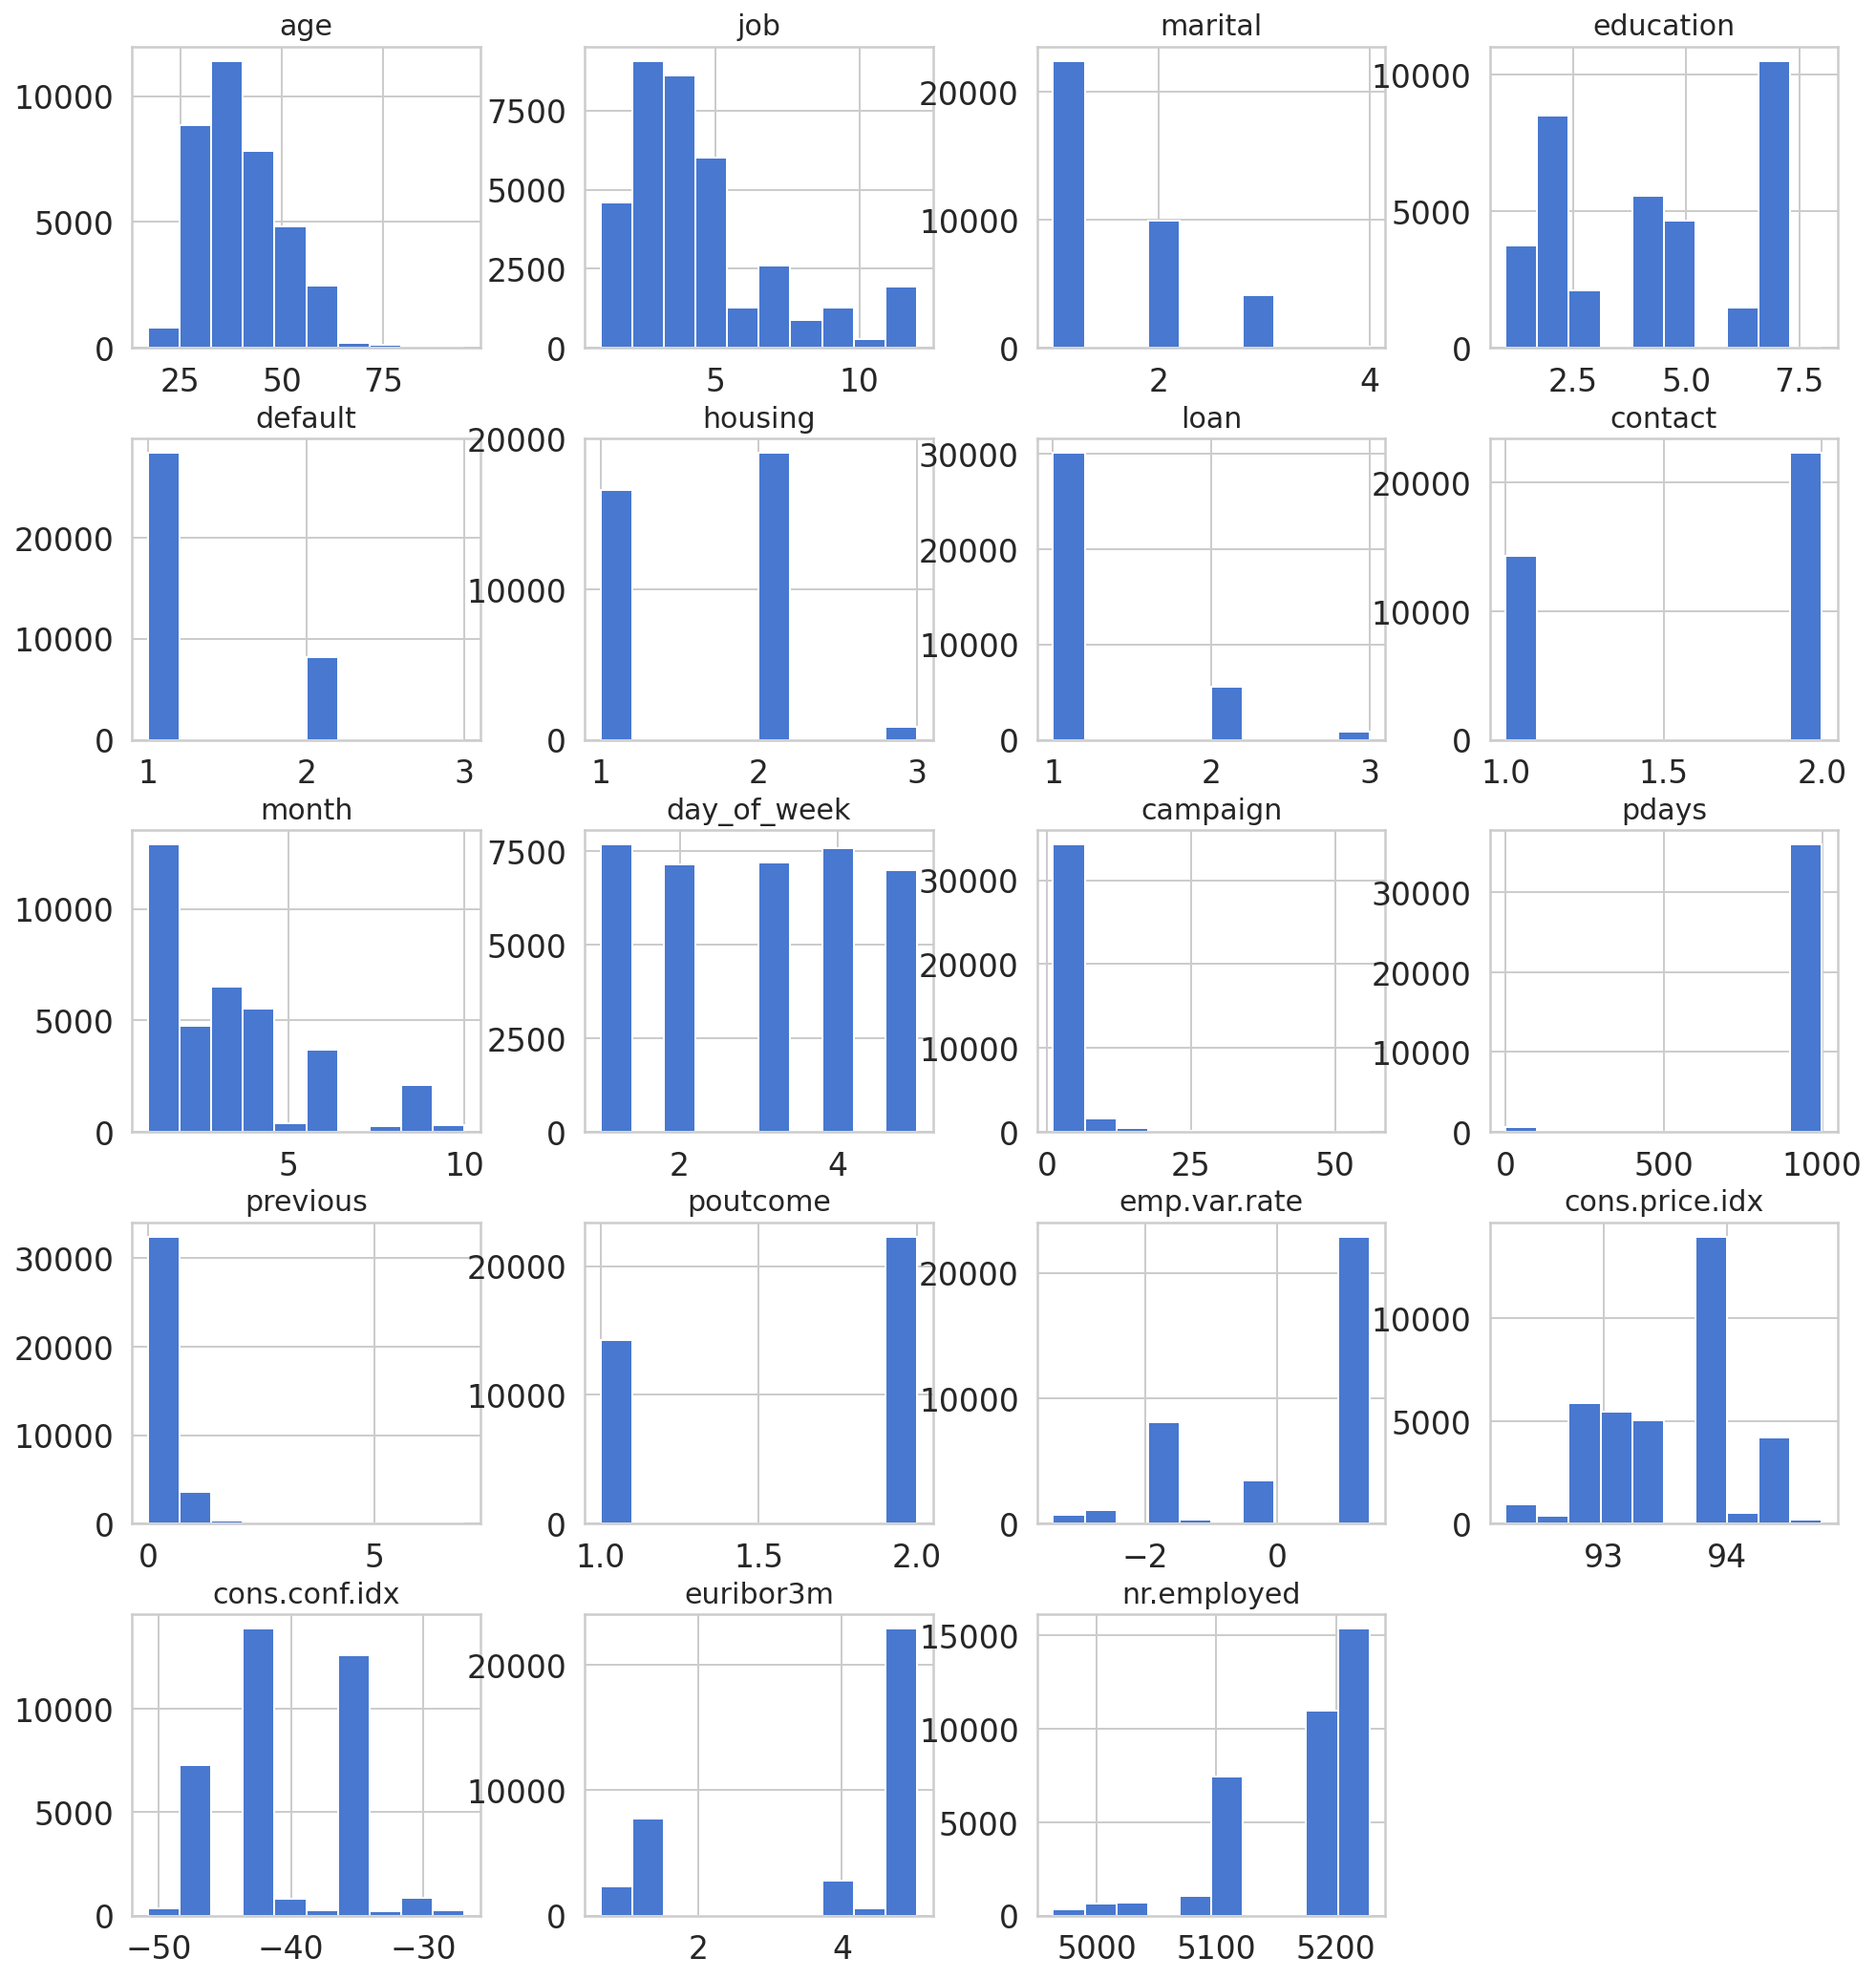

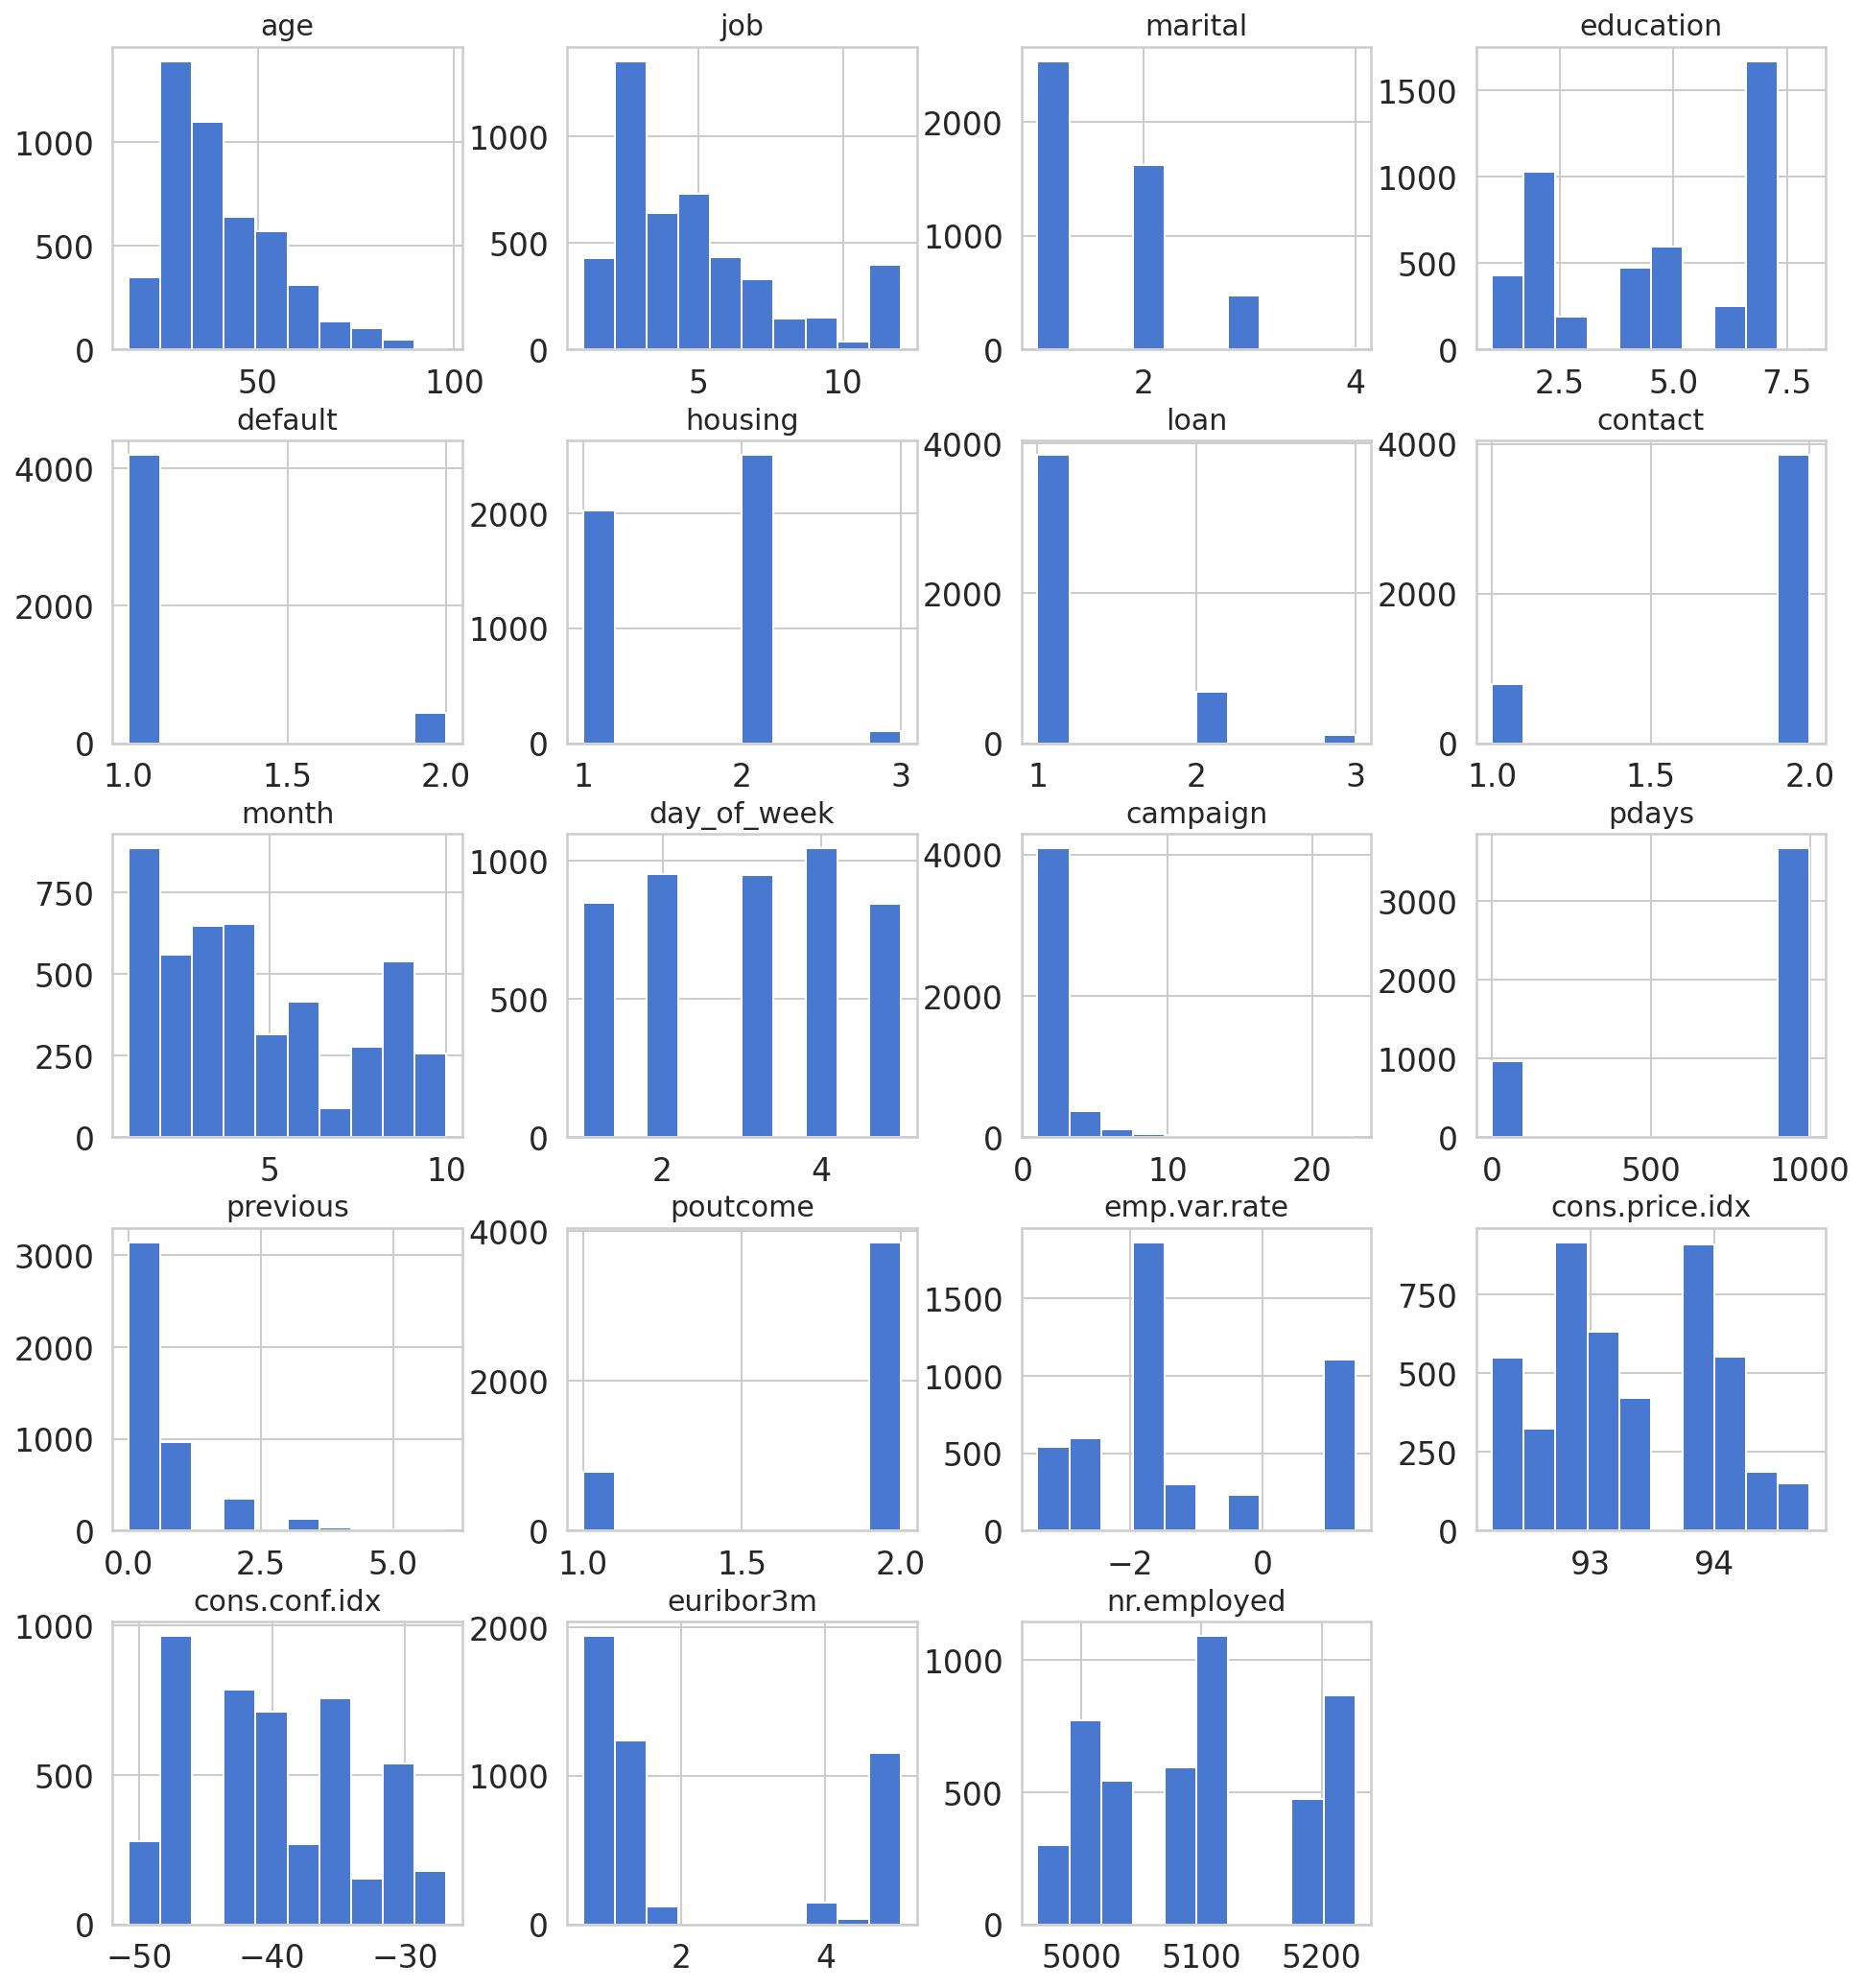

In [64]:
df.info()

df['job'] = pd.factorize(df['job'])[0] + 1
df['marital'] = pd.factorize(df['marital'])[0] + 1
df['education'] = pd.factorize(df['education'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['housing'] = pd.factorize(df['housing'])[0] + 1
df['default'] = pd.factorize(df['default'])[0] + 1
df['loan'] = pd.factorize(df['loan'])[0] + 1
df['contact'] = pd.factorize(df['contact'])[0] + 1
df['month'] = pd.factorize(df['month'])[0] + 1
df['day_of_week'] = pd.factorize(df['day_of_week'])[0] + 1
df['poutcome'] = pd.factorize(df['contact'])[0] + 1

# Should remove - duration as only for benchmark
df = df.drop('duration', 1)

df.groupby('target').hist(figsize = (16,18))

df['previously_contacted'] = df.pdays.apply(lambda x: 0 if x == 999 else 1)
df = df.drop('pdays', 1)

nr.employed            -0.354678
euribor3m              -0.307771
emp.var.rate           -0.298334
cons.price.idx         -0.136211
default                -0.099352
campaign               -0.066357
loan                   -0.005038
housing                 0.009552
day_of_week             0.010051
marital                 0.026302
age                     0.030399
education               0.045721
job                     0.054793
cons.conf.idx           0.054878
poutcome                0.144773
contact                 0.144773
month                   0.183471
previous                0.230181
previously_contacted    0.324877
target                  1.000000
Name: target, dtype: float64


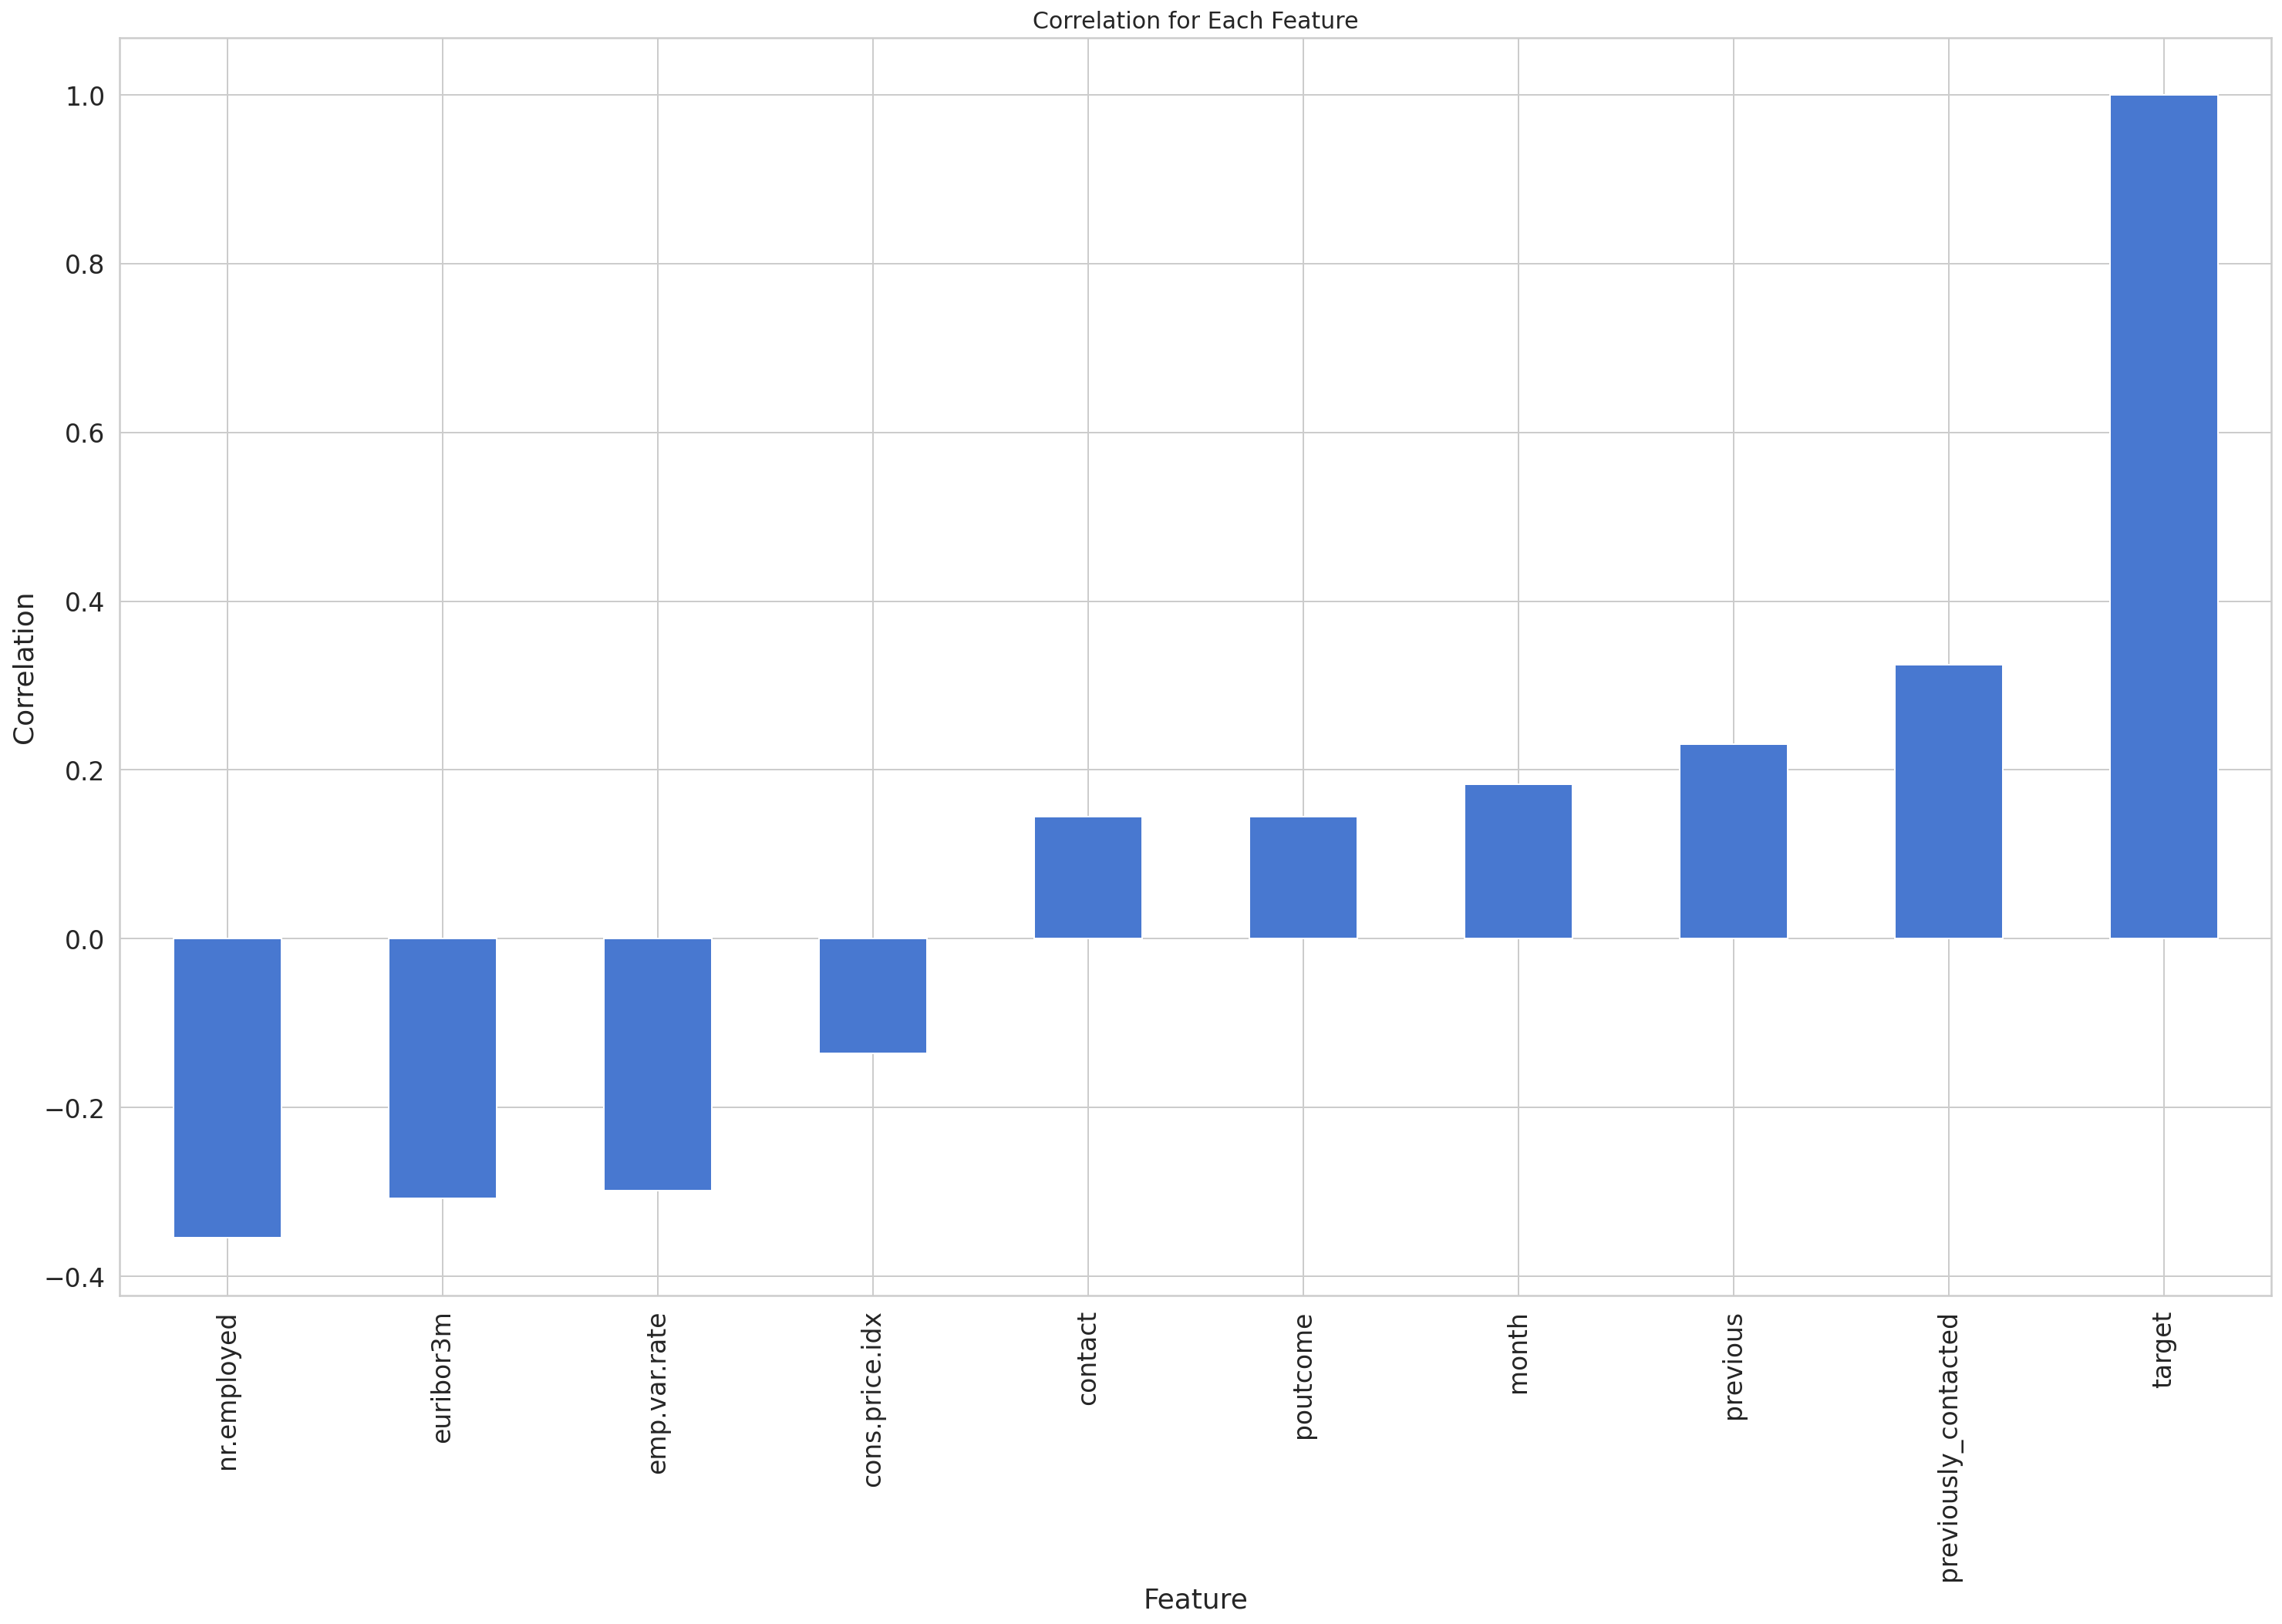

In [87]:
# # Create correlation matrix
std_features_keep = df
corr_matrix = std_features_keep.corr()['target'].sort_values()
print(corr_matrix)
threshold = 0.1

for  i, v in corr_matrix.iteritems():
    if(abs(v) < threshold):
      std_features_keep = std_features_keep.drop(i, axis=1)

# Plot for correlation
SMALL_SIZE = 15
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
std_plot = (std_features_keep.corr()['target'].sort_values()).plot(kind="bar",figsize=(25,15))
plt.xlabel('Feature')
plt.ylabel('Correlation')
plt.title('Correlation for Each Feature')
plt.show()

## Neural Network

In [67]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [88]:
BATCH_SIZE = 2048


import keras
from keras import backend as K
import tensorflow as tf

# Define our custom loss function
learning_rate = 0.001
def build_model(train_data,output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
    keras.layers.Dense(
      units=36, 
      activation='relu',
      input_shape=(train_data.shape[-1],)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS
  )

  return model

# Metrics

In [89]:
from sklearn.metrics import confusion_matrix

def plot_cm(labels, predictions, p=0.5):

  tick_labels = ['Y', 'N']

  cm = confusion_matrix(labels, predictions > p)
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

  print('% right for no: ', cm[0][0]/(cm[0][0] + cm[0][1]))
  print('% right for yes: ', cm[1][1]/(cm[1][1] + cm[1][0]))

In [90]:
from sklearn.metrics import f1_score

def print_metrics(model, evaluation_results, predictions):
  for name, value in zip(model.metrics_names, evaluation_results):
    print(name, ': ', value)
  print(f'f1 score: {f1_score(y_test, np.round(y_pred.flatten()))}')
  print()

# Create Model

In [91]:
from sklearn.model_selection import train_test_split

X = std_features_keep.drop(i, axis=1)
y = df['target']

labels = X.columns.values

from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

# Print mean and standard deviation
print("Mean:", round(X[:,0].mean()))
print("Standard deviation:", X[:,0].std())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=RANDOM_SEED)

Mean: 0
Standard deviation: 1.0000000000000002


# Weighted model

In [92]:
no_claim_count, claim_count = np.bincount(df.target)
total_count = len(df.target)

weight_no_claim = (1 / no_claim_count) * (total_count) / 2.0 
weight_claim = ((1 / claim_count) * (total_count) / 2.0 ) 
print("no claim:  " + str(weight_no_claim))
print("claim:  " + str(weight_claim))
class_weights = {0: weight_no_claim, 1: weight_claim}

no claim:  0.5634781656999015
claim:  4.438362068965517


In [93]:
initial_bias = np.log([claim/no_claim])
model_weighted = build_model(X_train, initial_bias)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

history_weighted = model_weighted.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    shuffle=True,
    class_weight=class_weights
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
20/20 [==============================] - 3s 75ms/step - loss: 1.2449 - tp: 611.0000 - fp: 1849.0000 - tn: 34699.0000 - fn: 4029.0000 - accuracy: 0.8573 - precision: 0.2484 - recall: 0.1317 - auc: 0.5008 - val_loss: 0.3429 - val_tp: 6.0000 - val_fp: 6.0000 - val_tn: 1817.0000 - val_fn: 231.0000 - val_accuracy: 0.8850 - val_precision: 0.5000 - val_recall: 0.0253 - val_auc: 0.7004
Epoch 2/100
20/20 [==============================] - 0s 12ms/step - loss: 0.8314 - tp: 1590.0000 - fp: 3092.0000 - tn: 31633.0000 - fn: 2813.0000 - accuracy: 0.8491 - precision: 0.3396 - recall: 0.3611 - auc: 0.7149 - val_loss: 0.3372 - val_tp: 32.0000 - val_fp: 31.0000 - val_tn: 1792.0000 - val_fn: 205.0000 - val_accuracy: 0.8854 - val_precision: 0.5079 - val_recall: 0.1350 - val_auc: 0.7712
Epoch 3/100
20/20 [==============================] - 0s 12ms/step - loss: 0.7512 - tp: 2295.0000 - fp: 4809.0000 - tn: 29916.0000 - fn: 2108.0000 - accuracy: 0.8232 - precision: 0.3231 - recall: 0.5212 - auc: 0.

Evaluation

In [94]:
evaluation_results = model_weighted.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
y_pred = model_weighted.predict(X_test, batch_size=BATCH_SIZE)
print_metrics(model_weighted, evaluation_results, y_pred)

loss :  0.5259149074554443
tp :  142.0
fp :  265.0
tn :  1558.0
fn :  95.0
accuracy :  0.8252426981925964
precision :  0.3488943576812744
recall :  0.5991561412811279
auc :  0.7914667129516602
f1 score: 0.4409937888198758



% right for no:  0.8546352166758091
% right for yes:  0.5991561181434599


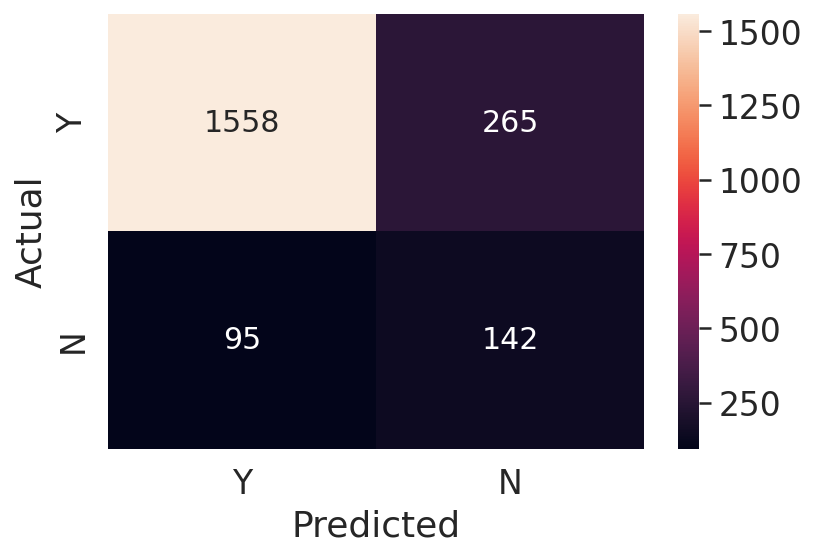

In [95]:
plot_cm(y_test, y_pred)

# Architecture

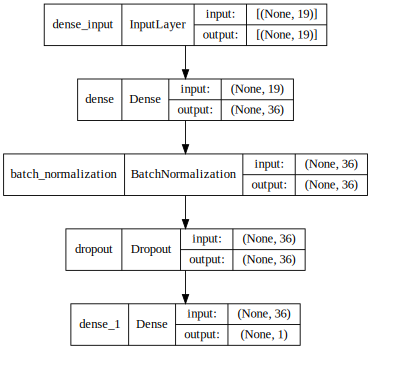

In [ ]:
from IPython.display import SVG
import tensorflow as tf
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_weighted, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))